# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState

RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка и подготовка данных

In [3]:
try:
    geo_data_0 = pd.read_csv('practicum\df_p09\geo_data_0.csv')
    geo_data_1 = pd.read_csv('practicum\df_p09\geo_data_1.csv')
    geo_data_2 = pd.read_csv('practicum\df_p09\geo_data_2.csv')
except:
    geo_data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')


### Первичный анализ данных

In [4]:
def head(db):
    display(db.info())
    display('-' * 50)
    display(db.head(2))
    display('-' * 50)

In [5]:
db = [geo_data_0, geo_data_1, geo_data_2]

for i in db:
    head(i)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

'--------------------------------------------------'

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.22117,105.280062
1,2acmU,1.334711,-0.340164,4.36508,73.037750


'--------------------------------------------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

'--------------------------------------------------'

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261


'--------------------------------------------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

'--------------------------------------------------'

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697


'--------------------------------------------------'

In [6]:
print('Колличество дубликатов в geo_data_0:', geo_data_0.duplicated().sum())
print('Колличество дубликатов в geo_data_1:', geo_data_1.duplicated().sum())
print('Колличество дубликатов в geo_data_2:', geo_data_2.duplicated().sum())

Колличество дубликатов в geo_data_0: 0
Колличество дубликатов в geo_data_1: 0
Колличество дубликатов в geo_data_2: 0


In [7]:
print('Колличество пропущенных значений в df_geo_0:')
print(geo_data_0.isnull().sum())
print('-' * 15)
print('Колличество пропущенных значений в df_geo_1:')
print(geo_data_0.isnull().sum())
print('-' * 15)
print('Колличество пропущенных значений в df_geo_2:')
print(geo_data_0.isnull().sum())
print('-' * 15)

Колличество пропущенных значений в df_geo_0:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
---------------
Колличество пропущенных значений в df_geo_1:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
---------------
Колличество пропущенных значений в df_geo_2:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
---------------


__Вывод__  
На основе EDA можно сделать следующие выводы:  
В данных нет пропускоов, нет дубликатов, нет пропусков:- данные чистые.

In [8]:
display('Статистическое описание geo_data_0:')
display(geo_data_0.describe().T)
display('-' * 100)
display('Статистическое описание geo_data_1:')
display(geo_data_1.describe().T)
display('-' * 100)
display('Статистическое описание geo_data_2:')
display(geo_data_2.describe().T)

'Статистическое описание geo_data_0:'

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


'----------------------------------------------------------------------------------------------------'

'Статистическое описание geo_data_1:'

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


'----------------------------------------------------------------------------------------------------'

'Статистическое описание geo_data_2:'

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


### Построение Boxplot на обзор выбросов

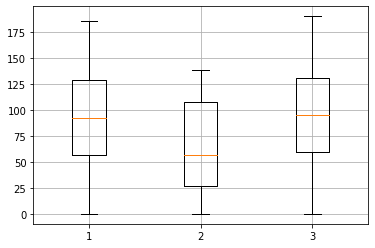

In [9]:
plt.boxplot([geo_data_0['product'], geo_data_1['product'], geo_data_2['product']])
plt.grid()
plt.show()

Выбросов нет.

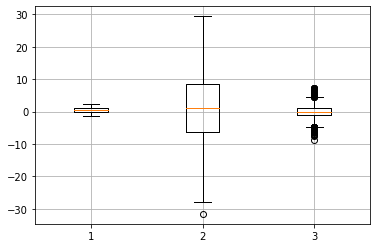

In [10]:
plt.boxplot([geo_data_0['f0'], geo_data_1['f0'], geo_data_2['f0']])
plt.grid()
plt.show()

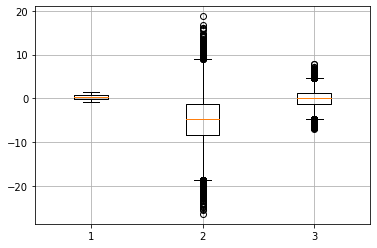

In [11]:
plt.boxplot([geo_data_0['f1'], geo_data_1['f1'], geo_data_2['f1']])
plt.grid()
plt.show()

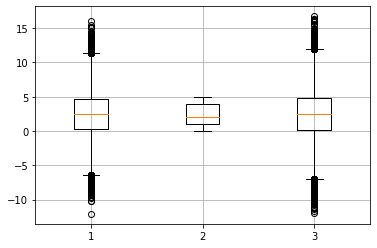

In [12]:
plt.boxplot([geo_data_0['f2'], geo_data_1['f2'], geo_data_2['f2']])
plt.grid()
plt.show()

__Вывод__  
Признаки f0, f1 и f2 не похожи между собой и зависят от региона. Имеются выбросы

### Проверка на мультиколлинеарность

In [13]:
def vif(db):
    columns =db.select_dtypes(exclude='object').columns.to_list()
    X = db[columns] # Выделяем "независимые" переменные (признаки)

    X_with_const = sm.add_constant(X) # Добавляем константу для использования модуля statsmodels

# Рассчитываем VIF для каждого признака
    vif = pd.DataFrame()
    vif['Feature'] = X_with_const.columns
    vif['vif'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

    display(vif.round(2)) # Выводим результаты

In [14]:
vif(geo_data_0)

,Feature,vif
0,const,6.86
1,f0,1.25
2,f1,1.28
3,f2,1.32
4,product,1.38


In [15]:
vif(geo_data_1)

,Feature,vif
0,const,7.56
1,f0,3.16
2,f1,1.05
3,f2,2660.14
4,product,2662.65


In [16]:
vif(geo_data_2)

,Feature,vif
0,const,5.57
1,f0,1.00
2,f1,1.00
3,f2,1.25
4,product,1.25


__Вывод__  
VIF измеряет насколько дисперсия коэффициента увеличивается, когда предикторы коррелированы. Если VIF = 1, переменные не коррелированы. Если VIF > 5-10, то существует проблема мультиколлинеарности. На основе полученных значений VIF можно сделать следующие выводы:

geo_data_1 имеет серьезные проблемы с мультиколлинеарностью между признаками f2 и product. В этом случае, возможно, потребуется принять меры, такие как удаление одного из этих признаков;

geo_data_0 и geo_data_2 не имеет проблем с мультиколлинеарностью, и модель будет стабильной.

### Рассмотрение распределение значений

Посмотрим линейное распределение меоду обьеденёнными признаками и целевой переменной "product", также расчитаем коэффициент корреляции Пирсона.

In [17]:
def scatterplot(df):
    test = df.copy()
    test['summ'] = test['f0'] + test['f1'] + test['f2']
    sns.scatterplot(data = test, x=test['summ'], y = test['product']);
    plt.title('Распределение между объединенными значениями f0, f1, f2 и product')
    plt.show()
    
    cor = test['product'].corr(test['summ']).round(2)
    print(f'Коэффициент корреляции Пирсона между объединенными признаками и product: {cor:.2f}')

Нулевой регион:


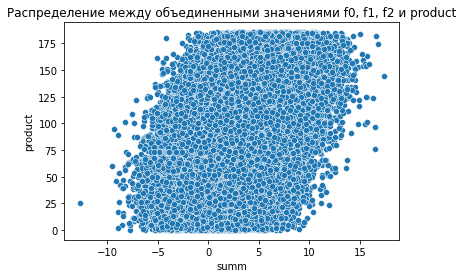

Коэффициент корреляции Пирсона между объединенными признаками и product: 0.48
****************************************************************************************************
Первый регион:


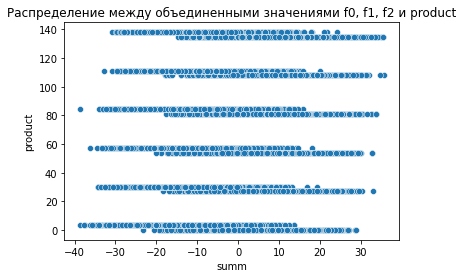

Коэффициент корреляции Пирсона между объединенными признаками и product: 0.12
****************************************************************************************************
Второй регион:


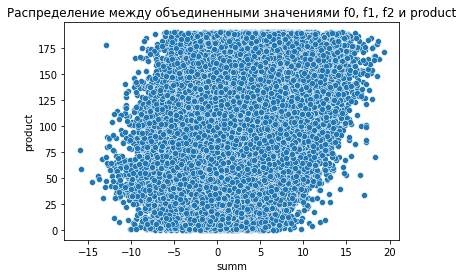

Коэффициент корреляции Пирсона между объединенными признаками и product: 0.36


In [18]:

print('Нулевой регион:')
scatterplot(geo_data_0)
print('*' * 100)
print('Первый регион:')
scatterplot(geo_data_1)
print('*' * 100)
print('Второй регион:')
scatterplot(geo_data_2)

__Вывод__  
На основании полученных данных ол плотности распределения и значения коэффициента корреляции Пирсона можно придти к следующим выводам:  
1) Нулевой и второй регион имеют хорошо просматривуемую линейную зависимость, как и коэффициент корреляции Пирсона находится в допустимых приделах, следовательно модель должна быть стобильной.
2) Первый регион имеет неустойчевые данные к линейной зависимости.

__Итог:__  
Все данные "чистые" и подходят для обечения, вопросы вызывает только Первый регион: __geo_data_1__

## Обучение и проверка модели

### Подготовка данных к обучению

In [19]:
#Нулевой регион
X0 = geo_data_0.drop(['id', 'product'],  axis=1)
y0 = geo_data_0['product']
# Разделим данныхе на обучающую (75%) и валидационную (25%) выборку
X_train_0, X_val_0, y_train_0, y_val_0 = train_test_split(X0, y0, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [20]:
#Первый регион
X1 = geo_data_1.drop(['id', 'product'],  axis=1)
y1 = geo_data_1['product']
# Разделим данныхе на обучающую (75%) и валидационную (25%) выборку
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X1, y1, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [21]:
#Второй регион
X2 = geo_data_2.drop(['id', 'product'],  axis=1)
y2 = geo_data_2['product']
# Разделим данныхе на обучающую (75%) и валидационную (25%) выборку
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X2, y2, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [22]:
# проверяем результат
print('Train sample:',      X_train_1.shape, y_train_1.shape)
print('Validation sample:', X_val_1.shape, y_val_1.shape)

Train sample: (75000, 3) (75000,)
Validation sample: (25000, 3) (25000,)


___Функция оценки модели___

In [23]:
def def_LinearRegration(y_pred, y_val): 
    # оценка модели
    mse = mean_squared_error(y_val, y_pred)
    rmse = round(np.sqrt(mse), 2)
    average = round(y_pred.mean(), 2)
    print(f'RMSE: {rmse}')
    print(f'Среденее значение: {average}')
    

In [24]:
model = LinearRegression() # создание модель линейной регрессии

In [25]:
model.fit(X_train_0, y_train_0) # обучаем
y_pred_0 = model.predict(X_val_0)

In [26]:
print('Нулевой регион:')
def_LinearRegration(y_pred_0, y_val_0)

Нулевой регион:
RMSE: 37.76
Среденее значение: 92.4


In [27]:
model.fit(X_train_1, y_train_1) # обучаем
y_pred_1 = model.predict(X_val_1)

In [28]:
print('Первый регион:')
def_LinearRegration(y_pred_1, y_val_1)

Первый регион:
RMSE: 0.89
Среденее значение: 68.71


In [29]:
model.fit(X_train_2, y_train_2) # обучаем
y_pred_2 = model.predict(X_val_2)

In [30]:
print('Второй регион:')
def_LinearRegration(y_pred_2, y_val_2)

Второй регион:
RMSE: 40.15
Среденее значение: 94.77


Лучшие метрики показывает модель, предсказавшая значения первого региона, что вероятно связанно с функциональной (линейной) зависимостью f1 и product. Однако среднее значение продукта минимально для 1-го региона.

## Подготовка к расчёту прибыли

In [52]:
# Задаем коснтанты
POINT_OF_INT = 500               # кол-во точек для исследования
TOP_WELLS = 200                  # кол-во наилучших скважин
BUDGET_PER_REGION = 1e10         # бюджет на разработку скважин в регионе
PRICE_PER_PRODUCT_UNIT = 450_000  # цена единицы продукта
THRESHOLD = 0.025                # пороговая вероятность убытков

In [43]:
print('Среднее значение продукта в 0-м регионе: ', round(y_pred_0.mean(), 2))
print('Среднее значение продукта во 1-м регионе:', round(y_pred_1.mean(), 2))
print('Среднее значение в 2-м регионе:          ', round(y_pred_2.mean(), 2))

Среднее значение продукта в 0-м регионе:  92.4
Среднее значение продукта во 1-м регионе: 68.71
Среднее значение в 2-м регионе:           94.77


In [44]:
min_volue = BUDGET_PER_REGION / (TOP_WELLS * PRICE_PER_PRODUCT_UNIT)

print(f'Минимальное кол-во продукта с одной скважины: {min_volue:.2f} тыс. барелей')

Минимальное кол-во продукта с одной скважины: 111.11 тыс. барелей


__Вывод:__  
Из полученных данных можно предположить, что все скважены будут убыточны.

## Расчёт прибыли и рисков 

In [45]:
def profit(preds_subsample, subsample): # ф-ция возвращает доход региона в мил.  
    preds_sorted =  preds_subsample.sort_values(ascending=False).iloc[:TOP_WELLS]
    selected = subsample[preds_sorted.index]
    return round((PRICE_PER_PRODUCT_UNIT * selected.sum()) - BUDGET_PER_REGION, 2) / 1e6

### Посчитайте риски и прибыль для каждого региона

In [46]:
def bootstrap(predictions, target):
    predictions = pd.Series(predictions, index=target.index)    
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        subsample = target.sample(n=POINT_OF_INT, replace=True, random_state=state)
        preds_subsample = predictions[subsample.index]
        rev = profit(preds_subsample, subsample)
        values.append(rev)
    
    # конвертирование списка в серию для удобства и вычисление риска
    values = pd.Series(values)
    risk = values[values < 0].count() / len(preds_subsample)
    
    # условие оценки риска
    assesment = 'Удовлетворяет условию'
    if risk >= THRESHOLD:
        assesment = 'НЕ удовлетворяет условию'
    
             
    # границы 95% доверительного интервала
    lower = values.quantile(q=0.025) 
    upper = values.quantile(q=0.975)
    print(f'95% доверительный интервал: ({lower:.0f}, {upper:.0f}) [млн. руб.]')
    print(f'Средняя прибыль: {values.mean():.0f} млн. руб.')
    print(f'Вероятность риска: {risk:.2%} => {assesment}')

In [51]:
print('Нулевой регион:')
bootstrap(y_pred_0, y_val_0)

Нулевой регион:
95% доверительный интервал: (-21, 1240) [млн. руб.]
Средняя прибыль: 615 млн. руб.
Вероятность риска: 6.00% => НЕ удовлетворяет условию


In [48]:
print('Первый регион:')
bootstrap(y_pred_1, y_val_1)

Первый регион:
95% доверительный интервал: (142, 1195) [млн. руб.]
Средняя прибыль: 640 млн. руб.
Вероятность риска: 0.80% => Удовлетворяет условию


In [49]:
print('Второй регион:')
bootstrap(y_pred_2, y_val_2)

Второй регион:
95% доверительный интервал: (-8, 1283) [млн. руб.]
Средняя прибыль: 587 млн. руб.
Вероятность риска: 5.20% => НЕ удовлетворяет условию


__Общий вывод__  

В ходе проекта была поставлена задача выбора удачного региона для добычи нефти и выданы датасеты с характеристиками скважин в трёх регионах. Для решения поставленной задачи использовалась (по условию) модель машинного обучения линейная регрессия, расчитывющая объём продукции по характерстикам скважины. Мы установили так же, что регионы в среднем убыточны. Далее методом bootstrap было получено распределение прибыли для каждого региона, найден 95% доверительный интервал и произведена оценка рисков. По условию среди регионов с риском убытков менее 2.5% выбирается регион с наибольшей средней прибылью. Исходя из этого к разработке скважин рекомендуется регион №1, т.к. единственный показал низкие риски.